# The DataStats Multivar Module

The datastats.multivar module has various functions for working with relationships between variables. Most of the functions are for use in regression analysis, but there are a few function for other types of analysis too.

This notebook will demonstrate how some of the functions in this module can be used.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import patsy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datastats.multivar as dsmv
from datastats.singlevar import PValueFromEstimates, DiscreteRv

## ResampleInterSlope

ResampleInterSlope uses sampling with replacement to generate intercept and slope sampling distributions for two variables of interest. These sampling distributions can then be used in hypothesis testing.  

It also generates a list of 'y' sequences (fit_ys_list), one for each fitline created during the resampling procedure, that can be run through datastats.multivar.PercentileRows to get the high/low lines for adding a CI to a regression plot. Adding these lines, in combination with the fit line generated from the datastats.multivar.FitLine function, on a scatterplot produces a plot that mimics the one produced by seaborn regplot, but it's produced entirely using non-parametric computational methods.  

This usage is demonstrated below.  

For these examples I will use the seaborn 'mpg' (cars) data set.

In [2]:
df=sns.load_dataset("mpg")
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


I have chosen to look at the relationship between car weight and miles per gallon (mpg) which shows a relatively clear linear relationship.  

First, I'll plot the data and add a fit line using datastats.multivar.FitLine function.

In [3]:
regress_results = stats.linregress(df.weight, df.mpg)
print('intercept:', regress_results.intercept, 'slope:',regress_results.slope)

intercept: 46.31736442026563 slope: -0.007676610063926467


In [4]:
fit_xs, fit_ys = dsmv.FitLine(df.weight, regress_results.intercept, regress_results.slope)

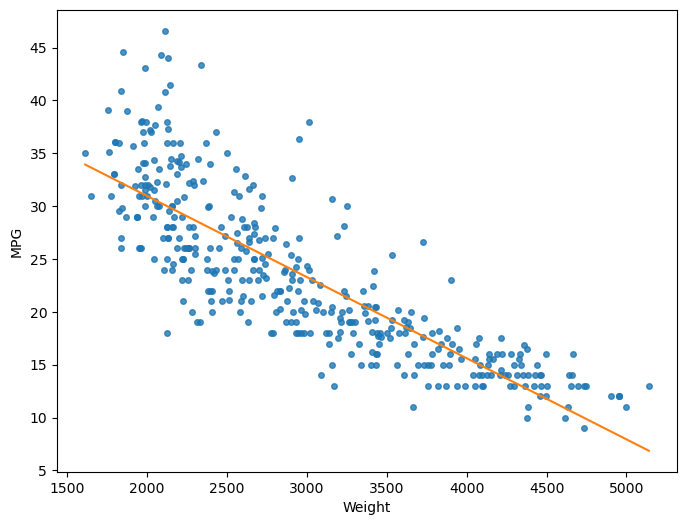

In [5]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.scatter(df.weight, df.mpg, color='C0', s=16, alpha=0.8)
ax.plot(fit_xs, fit_ys, color='C1')

ax.set_xlabel('Weight')
ax.set_ylabel('MPG')

plt.show()

Next we will use ResampleInterSlope to produce sampling distributions for the intercept and slope, as well as the fit_ys_list that will be run through PercentileRows to select the lines that will be added to our scatterplot to include a CI.

In [6]:
# Set random seed for reproducibility
np.random.seed(222)

In [7]:
inters, slopes, fit_ys_list = dsmv.ResampleInterSlope(df.weight, df.mpg)

Just to demonstrate how the sampling distributions can be used in hypothesis testing I will use datastats.singlevar.PValueFromEstimates (imported above) with a hypothesized test_statistic of -0.008.

In [8]:
print('{:.3f}'.format(PValueFromEstimates(slopes, -0.008, tail='left')))

0.096


This can be visualized by plotting the cdf of the slope sampling distribution with a vertical line for the test statistic. Lines representing the CI and the mean are also included.

In [9]:
# Create a random variable for the slope sampling distribution using datastats.singlevar.DiscreteRv (imported above)
slopes_rv = DiscreteRv(slopes)

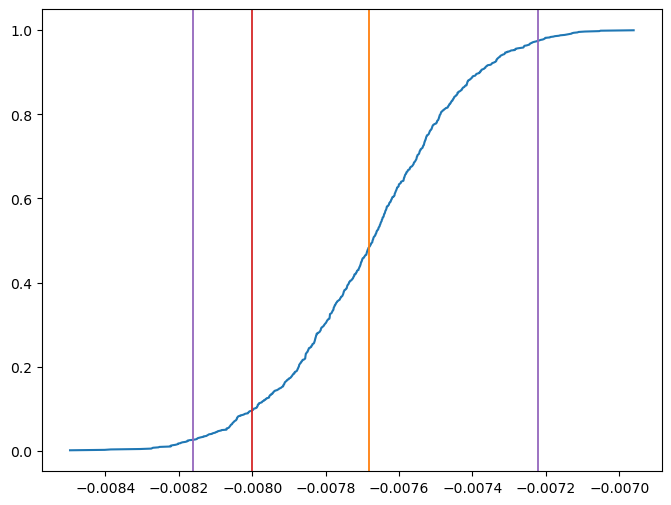

In [10]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

ax.plot(slopes_rv.xk, slopes_rv.cdf(slopes_rv.xk))
ax.axvline(slopes_rv.mean(), color='C1', lw=1.3) # mean, orange line
ax.axvline(slopes_rv.interval(0.95)[0], color='C4', lw=1.3, label='CI') # CI lower, purple line
ax.axvline(slopes_rv.interval(0.95)[1], color='C4', lw=1.3) # CI upper, purple line
ax.axvline(-0.008, color='C3', lw=1.3) # test statistic, red line

plt.show()

Next I will run the fit_ys_list produced by ResampleInterSlope through the PercentileRows function to produce lines that will show a 95% confidence interval around our best fit line on the scatter plot.  

I will then show our plot next to a seaborn equivalent for comparison.

In [11]:
percentile_rows = dsmv.PercentileRows(fit_ys_list, [2.5,97.5])

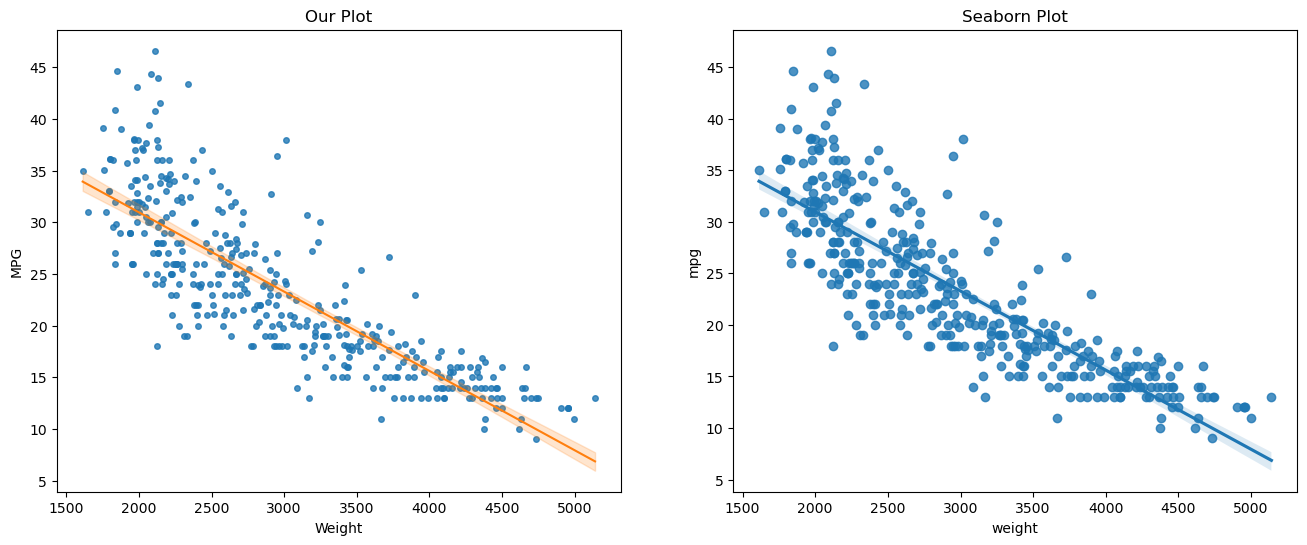

In [12]:
# Set up figure
fig,axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(16,6)

# Our regression plot
axes[0].scatter(df.weight, df.mpg, color='C0', s=16, alpha=0.8)
axes[0].plot(fit_xs, fit_ys, color='C1')
axes[0].fill_between(fit_xs, percentile_rows[0], percentile_rows[1], color='C1', alpha=0.2)

axes[0].set_xlabel('Weight')
axes[0].set_ylabel('MPG')
axes[0].set_title('Our Plot')

# Seaborn regression plot
sns.regplot(x='weight', y='mpg', data=df, ax=axes[1])
axes[1].set_title('Seaborn Plot')

plt.show()

## ResidualPercentilePlotData

Here I'll demonstrate how the ResidualPercentilePlotData function is used.  

This function generates values that are used in a residual percentile plot which helps with visualizing residuals when trying to determine fit with a linear model.
It bins the data and returns two items:  
- x_means = a list of the means for each bin  
- res_rvs = a list of rvs(scipy.stats DiscreteRv objects) containing the residual data for each bin  

I'll use the same data set and variables as above for this.

In [13]:
x_means, res_rvs = dsmv.ResidualPercentilePlotData(df.weight, df.mpg, n_bins=10)

The variables produced above (x_means, res_rvs) can then be used to produce a residual percentile plot as shown below.

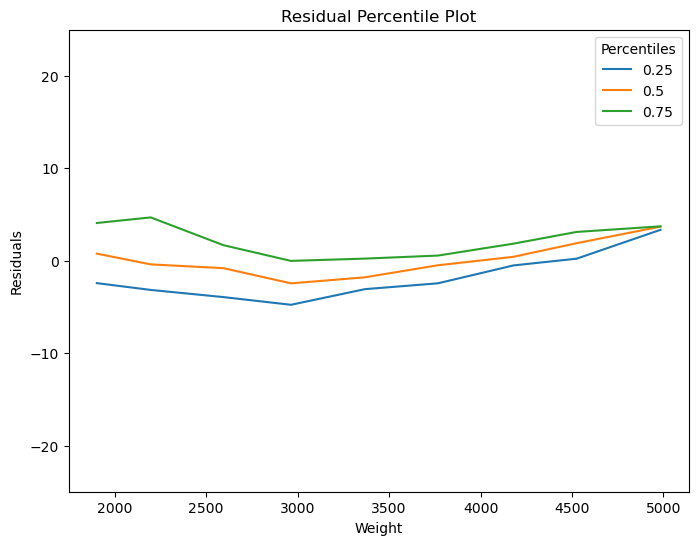

In [14]:
fig,ax = plt.subplots()
fig.set_size_inches(8,6)

# Residual percentile plot
percentiles = [.25,.50,.75]

for p in percentiles:
    residual_values_at_p = [rv.ppf(p) for rv in res_rvs]
    ax.plot(x_means, residual_values_at_p, label= p)

# I set the y-range to be the same scale as that of the scatter plot
ax.set_ylim(-25,25)

ax.set_xlabel('Weight')
ax.set_ylabel('Residuals')
ax.set_title('Residual Percentile Plot')
ax.legend(title='Percentiles')

plt.show()

In the datastats.plotting module there is a function called LinRegPlusResidualPlot that can be used to produce a side-by-side plot of a regression line and a residual percentile plot. In the 'DataStats Plotting Usage Demos' notebook you can find a demonstration on how to use this function that includes a detailed explanation on how to interpret what is displayed in the residual percentile plot.

## VariableMiningOLS

This function can be used to in data mining for ordinary least squares (OLS) regression. Given a dataframe and a target dependent variable from the dataframe, this function runs simple linear regression with each variable in the dataframe. It then returns a list of tuples. Each tuple consists of the r-squared value from the regression and the name of the variable. It only returns results for numerical variables in the dataframe.  

There are also similar functions in the module for different types of regression including logistic, poisson, and multinomial logistic regression.

I will once again use the mpg data set for this demonstration of VariableMiningOLS.

In [15]:
mining_results = dsmv.VariableMiningOLS(df, 'mpg')
mining_results

[(1.0, 'mpg'),
 (0.6012393994439938, 'cylinders'),
 (0.6467421834257859, 'displacement'),
 (0.6059482578894348, 'horsepower'),
 (0.6917929800341573, 'weight'),
 (0.17664276963558934, 'acceleration'),
 (0.3355504114705564, 'model_year')]

Looking at the mining results, variables to be used in a model can be selected, and a model generated using the OLS function from statsmodels.formula.api.

In [16]:
formula = 'mpg ~ displacement + horsepower + weight + model_year'
model = smf.ols(formula, data=df)
results = model.fit()

In [17]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     408.1
Date:                Wed, 28 Dec 2022   Prob (F-statistic):          2.24e-137
Time:                        08:25:28   Log-Likelihood:                -1037.4
No. Observations:                 392   AIC:                             2085.
Df Residuals:                     387   BIC:                             2105.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -13.6110      4.198     -3.242      0.001     -21.866      -5.357
displacement     0.0018      0.005      0.343      0.731      -0.009       0.012
horsepower      -0.0067      0.011     -0.628      0.530      -0.028       0.014
weight          -0.0066      0.001    -11.300      0.000      -0.008      -0.005
model_year       0.7505      0.052     14.312      0.000       0.647       0.854
==============================================================================
Omnibus:                       41.360   Durbin-Watson:                   1.229
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.034
Skew:                           0.666   Prob(JB):                     1.69e-15
Kurtosis:                       4.547   Cond. No.                     7.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## SummarizeRegressionResults

This function displays important parts of the regression results. For each variable the coefficient and p-value are printed. Std(ys) shows what the RMSE is without the predictor variables. Std(res) shows what the RMSE is with the predictor variables.

In [18]:
dsmv.SummarizeRegressionResults(results)

Intercept   -13.6   (0.00129)
displacement   0.00184   (0.731)
horsepower   -0.00669   (0.53)
weight   -0.00659   (8.84e-26)
model_year   0.75   (1.37e-37)
R^2 0.8084
Std(ys) 7.795
Std(res) 3.417
